[link](https://www.kaggle.com/budincsevity/szeged-weather)

Импорт библиотек

In [8]:
import importlib

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from scipy import stats
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor, SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
import shap

import ml_pipe

importlib.reload(ml_pipe)

# версии библиотек
print("Версии библиотек:")
import pkg_resources
import platform

print(f"python=={platform.python_version()}")

# list packages to be checked
root_packages = [
    'pandas', 'numpy', 'matplotlib', 'plotly', 'scikit-learn'
]
# print versions, but check if package is imported first
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print(f"{m.project_name}=={m.version}")

Версии библиотек:
python==3.9.7
plotly==5.5.0
matplotlib==3.5.1
numpy==1.20.3
pandas==1.3.4
scikit-learn==1.0.2


Константы

In [2]:
# pandas
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None

# plotly
pio.templates.default = "plotly_dark"  # plotly_dark seaborn
pio.renderers.default = "svg"  # svg notebook_connected plotly_mimetype

# sklearn
rng = np.random.RandomState(0)

In [6]:
df = pd.read_csv('datasets/weather_in_szeged/weatherHistory.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [7]:
df = ml_pipe.pythonic_names(df)

display(df.columns)

Index(['formatted_date', 'summary', 'precip_type', 'temperature_(c)',
       'apparent_temperature_(c)', 'humidity', 'wind_speed_(km/h)',
       'wind_bearing_(degrees)', 'visibility_(km)', 'loud_cover',
       'pressure_(millibars)', 'daily_summary'],
      dtype='object')

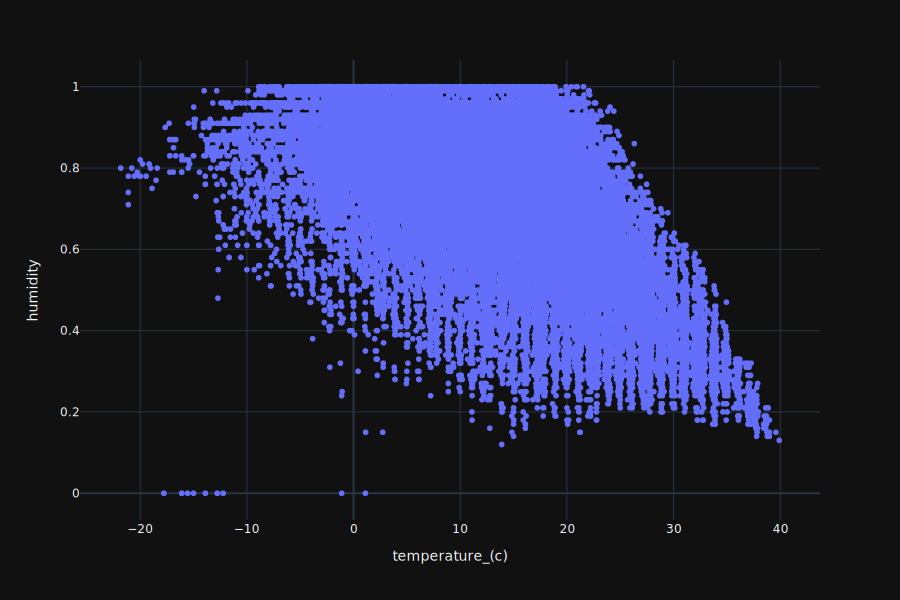

In [6]:
px.scatter(df, x='temperature_(c)', y='humidity', width=900, height=600)

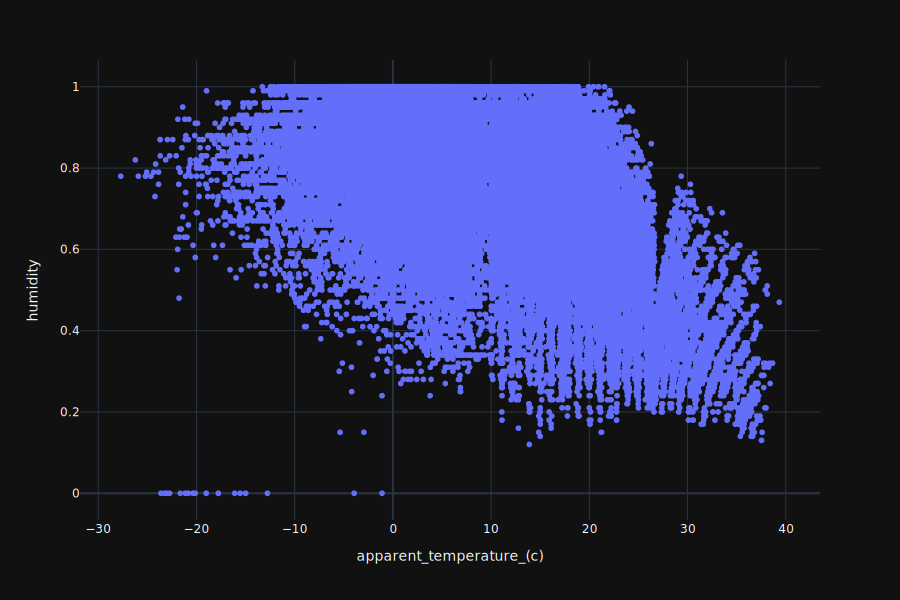

In [7]:
px.scatter(df, x='apparent_temperature_(c)', y='humidity', width=900, height=600)

# EDA


## summary

In [8]:
print(df['summary'].value_counts())

Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Humid and 

## precip_type

In [9]:
print(df['precip_type'].value_counts())

rain    85224
snow    10712
Name: precip_type, dtype: int64


## humidity


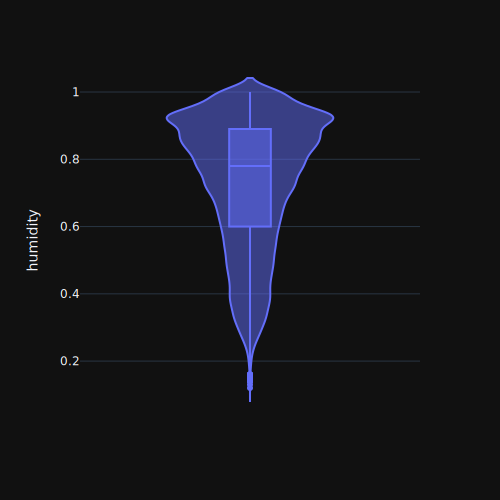

In [51]:
px.violin(df1, y='humidity', box=True, width=500, height=500)

Предобработка

In [52]:
df = (
    df[df['humidity'] > 0]
)

In [53]:
train, test = train_test_split(df, test_size=0.3, random_state=rng)

In [54]:
features = ['temperature_(c)', 'wind_speed_(km/h)', 'wind_bearing_(degrees)', 'precip_type', 'pressure_(millibars)']
features_scale = ['temperature_(c)', 'wind_speed_(km/h)', 'wind_bearing_(degrees)', 'pressure_(millibars)']
features_encode = ['precip_type']

target = ['humidity']

x_train = train[features]
x_test = test[features]
y_train = train[target]
y_test = test[target]

# Выбор модели

In [58]:
model_stat = pd.DataFrame()

pipe_preprocess = Pipeline(
    [
        ('impute', ml_pipe.SimpleImputerMy(['precip_type'], strategy='most_frequent')),
        ('encode', ml_pipe.OrdinalEncoderMy(features_encode)),
        ('scale', ml_pipe.StandardScalerMy(features_scale)),
    ]
)

## dummy

### DummyRegressor

In [15]:
pipe = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', DummyRegressor()),
    ]
)

search_params = {
    'model__strategy': ['mean', 'median'],
}

search = GridSearchCV(pipe, param_grid=search_params, verbose=20, scoring='r2', cv=3, n_jobs=-1)
search.fit(x_train, np.ravel(y_train))
print(search.best_score_)
print(search.best_params_)

final_dummy = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', DummyRegressor(
            strategy=search.best_params_['model__strategy'],
        )),
    ]
)
final_dummy.fit(x_train, np.ravel(y_train))

y_train_pred = final_dummy.predict(x_train)
y_test_pred = final_dummy.predict(x_test)

model_stat = ml_pipe.regression_report(model_stat, 'DummyRegressor', y_train, y_train_pred, y_test, y_test_pred)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
-2.834658758610331e-05
{'model__strategy': 'mean'}


R2                 MAE                 MSE            \
               train      test     train      test     train      test   
DummyRegressor   0.0 -0.000036  0.162969  0.162623  0.038248  0.038119   

                        MAPE                
                       train          test  
DummyRegressor  6.369548e+11  1.028922e+12

## tree

### DecisionTreeRegressor

In [16]:
pipe = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', DecisionTreeRegressor(random_state=rng)),
    ]
)

search_params = {
    'model__max_depth': range(3, 15),
}
search = GridSearchCV(pipe, param_grid=search_params, verbose=20, scoring='r2', cv=3, n_jobs=-1)
search.fit(x_train, np.ravel(y_train))
print(search.best_score_)
print(search.best_params_)

final_dtr = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', DecisionTreeRegressor(random_state=rng, max_depth=search.best_params_['model__max_depth'])),
    ]
)

final_dtr.fit(x_train, y_train)

y_train_pred = final_dtr.predict(x_train)
y_test_pred = final_dtr.predict(x_test)

model_stat = ml_pipe.regression_report(model_stat, 'DecisionTreeRegressor', y_train, y_train_pred, y_test, y_test_pred)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0.5766853999576641
{'model__max_depth': 8}


R2                 MAE                 MSE  \
                          train      test     train      test     train   
DummyRegressor         0.000000 -0.000036  0.162969  0.162623  0.038248   
DecisionTreeRegressor  0.602902  0.579580  0.095543  0.097982  0.015188   

                                         MAPE                
                           test         train          test  
DummyRegressor         0.038119  6.369548e+11  1.028922e+12  
DecisionTreeRegressor  0.016025  5.246596e+11  1.005508e+12

## ensemble

### RandomForestRegressor

In [59]:
pipe = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', RandomForestRegressor(
            n_jobs=-1,
            random_state=rng,
        )),
    ]
)

search_params = {
    'model__max_depth': range(8, 25),
    'model__max_features': ['auto'],  # range(2, len(features) + 1),
    'model__n_estimators': range(100, 500),
    'model__max_leaf_nodes': range(3000, 10001, 1000),
    'model__min_samples_split': range(2, 50),
    'model__min_samples_leaf': range(1, 20),
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=search_params,
    verbose=1,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=rng,
    n_iter=10,
)
search.fit(x_train, np.ravel(y_train))
print(search.best_score_)
print(search.best_params_)

final_rfc = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', RandomForestRegressor(
            max_depth=search.best_params_['model__max_depth'],
            max_features=search.best_params_['model__max_features'],
            n_estimators=search.best_params_['model__n_estimators'],
            n_jobs=-1,
            random_state=rng,
            max_leaf_nodes=search.best_params_['model__max_leaf_nodes'],
            min_samples_split=search.best_params_['model__min_samples_split'],
            min_samples_leaf=search.best_params_['model__min_samples_leaf'],
        )),
    ]
)
final_rfc.fit(x_train, np.ravel(y_train))

y_train_pred = final_rfc.predict(x_train)
y_test_pred = final_rfc.predict(x_test)

model_stat = ml_pipe.regression_report(model_stat, 'RandomForestRegressor', y_train, y_train_pred, y_test, y_test_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.618594701439728
{'model__n_estimators': 204, 'model__min_samples_split': 11, 'model__min_samples_leaf': 2, 'model__max_leaf_nodes': 6000, 'model__max_features': 'auto', 'model__max_depth': 16}


R2                 MAE                 MSE  \
                          train      test     train      test     train   
RandomForestRegressor  0.792542  0.624903  0.068406  0.091694  0.007907   

                                     MAPE          
                           test     train    test  
RandomForestRegressor  0.014272  0.109825  0.1491

### AdaBoostRegressor

In [18]:
pipe = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', AdaBoostRegressor(
            base_estimator=DecisionTreeRegressor(max_depth=8),
            random_state=1,
        )),
    ]
)

search_params = {
    'model__learning_rate': np.arange(0.0001, 0.5, 0.001),
    'model__n_estimators': range(20, 200),
}

search = RandomizedSearchCV(
    pipe, param_distributions=search_params, verbose=20, scoring='r2', cv=3, n_jobs=-1, random_state=rng
)
search.fit(x_train, np.ravel(y_train))
print(search.best_score_)
print(search.best_params_)

final_abr = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', AdaBoostRegressor(
            base_estimator=DecisionTreeRegressor(max_depth=10),
            n_estimators=search.best_params_['model__n_estimators'],
            learning_rate=search.best_params_['model__learning_rate'],
            random_state=1,
        )),
    ]
)
final_abr.fit(x_train, np.ravel(y_train))

y_train_pred = final_abr.predict(x_train)
y_test_pred = final_abr.predict(x_test)

model_stat = ml_pipe.regression_report(model_stat, 'AdaBoostRegressor', y_train, y_train_pred, y_test, y_test_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.5935920843530486
{'model__n_estimators': 97, 'model__learning_rate': 0.043100000000000006}


R2                 MAE                 MSE  \
                          train      test     train      test     train   
DummyRegressor         0.000000 -0.000036  0.162969  0.162623  0.038248   
DecisionTreeRegressor  0.602902  0.579580  0.095543  0.097982  0.015188   
AdaBoostRegressor      0.650266  0.607403  0.091728  0.096317  0.013377   
RandomForestRegressor  0.871115  0.628856  0.054302  0.091284  0.004930   

                                         MAPE                
                           test         train          test  
DummyRegressor         0.038119  6.369548e+11  1.028922e+12  
DecisionTreeRegressor  0.016025  5.246596e+11  1.005508e+12  
AdaBoostRegressor      0.014965  5.929173e+09  9.783481e+11  
RandomForestRegressor  0.014147  2.052352e+11  9.530373e+11

### HistGradientBoostingRegressor

In [61]:
pipe = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', HistGradientBoostingRegressor(
            random_state=rng,
        )),
    ]
)

search_params = {
    'model__max_iter': [15000],
    'model__learning_rate': stats.uniform(0.01, 0.2),
    'model__max_depth': [7],# range(5, 100, 5),
    'model__l2_regularization': stats.uniform(0, 2.0),
    'model__max_bins': [255],
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=search_params,
    verbose=1,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    random_state=rng,
    n_iter=50,
)
search.fit(x_train, np.ravel(y_train))
print(search.best_score_)
print(search.best_params_)

final_hgbr = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', HistGradientBoostingRegressor(
            max_iter=search.best_params_['model__max_iter'],
            learning_rate=search.best_params_['model__learning_rate'],
            max_depth=search.best_params_['model__max_depth'],
            l2_regularization=search.best_params_['model__l2_regularization'],
            random_state=rng,
            max_bins=search.best_params_['model__max_bins'],
        )),
    ]
)
final_hgbr.fit(x_train, np.ravel(y_train))

y_train_pred = final_hgbr.predict(x_train)
y_test_pred = final_hgbr.predict(x_test)

model_stat = ml_pipe.regression_report(
    model_stat, 'HistGradientBoostingRegressor', y_train, y_train_pred, y_test, y_test_pred
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.6183958883621206
{'model__l2_regularization': 0.2449341521173365, 'model__learning_rate': 0.08862714776207464, 'model__max_bins': 255, 'model__max_depth': 7, 'model__max_iter': 15000}


R2                 MAE            \
                                  train      test     train      test   
HistGradientBoostingRegressor  0.654831  0.618731  0.088749  0.093036   
RandomForestRegressor          0.792542  0.624903  0.068406  0.091694   

                                    MSE                MAPE            
                                  train      test     train      test  
HistGradientBoostingRegressor  0.013156  0.014506  0.144384  0.151286  
RandomForestRegressor          0.007907  0.014272  0.109825  0.149100

## linear_model

### LinearRegression

In [20]:
pipe = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', LinearRegression(n_jobs=-1)),
    ]
)

pipe.fit(x_train, np.ravel(y_train))

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

model_stat = ml_pipe.regression_report(model_stat, 'LinearRegression', y_train, y_train_pred, y_test, y_test_pred)

R2                 MAE            \
                                  train      test     train      test   
DummyRegressor                 0.000000 -0.000036  0.162969  0.162623   
LinearRegression               0.477308  0.476814  0.112162  0.111638   
DecisionTreeRegressor          0.602902  0.579580  0.095543  0.097982   
AdaBoostRegressor              0.650266  0.607403  0.091728  0.096317   
HistGradientBoostingRegressor  0.652760  0.618600  0.089171  0.093037   
RandomForestRegressor          0.871115  0.628856  0.054302  0.091284   

                                    MSE                    MAPE                
                                  train      test         train          test  
DummyRegressor                 0.038248  0.038119  6.369548e+11  1.028922e+12  
LinearRegression               0.019992  0.019943  8.944188e+11  1.414895e+12  
DecisionTreeRegressor          0.015188  0.016025  5.246596e+11  1.005508e+12  
AdaBoostRegressor              0.013377  0.014965  5.929173e+09  9.783481e+11  
HistGradientBoostingRegressor  0.013281  0.014538  5.527273e+11  1.047626e+12  
RandomForestRegressor          0.004930  0.014147  2.052352e+11  9.530373e+11

### PoissonRegressor

In [21]:
pipe = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', PoissonRegressor(max_iter=1000, alpha=0)),
    ]
)

pipe.fit(x_train, np.ravel(y_train))

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

model_stat = ml_pipe.regression_report(model_stat, 'PoissonRegressor', y_train, y_train_pred, y_test, y_test_pred)

R2                 MAE            \
                                  train      test     train      test   
DummyRegressor                 0.000000 -0.000036  0.162969  0.162623   
PoissonRegressor               0.442799  0.442387  0.116645  0.116096   
LinearRegression               0.477308  0.476814  0.112162  0.111638   
DecisionTreeRegressor          0.602902  0.579580  0.095543  0.097982   
AdaBoostRegressor              0.650266  0.607403  0.091728  0.096317   
HistGradientBoostingRegressor  0.652760  0.618600  0.089171  0.093037   
RandomForestRegressor          0.871115  0.628856  0.054302  0.091284   

                                    MSE                    MAPE                
                                  train      test         train          test  
DummyRegressor                 0.038248  0.038119  6.369548e+11  1.028922e+12  
PoissonRegressor               0.021312  0.021255  9.518402e+11  1.492667e+12  
LinearRegression               0.019992  0.019943  8.944188e+11  1.414895e+12  
DecisionTreeRegressor          0.015188  0.016025  5.246596e+11  1.005508e+12  
AdaBoostRegressor              0.013377  0.014965  5.929173e+09  9.783481e+11  
HistGradientBoostingRegressor  0.013281  0.014538  5.527273e+11  1.047626e+12  
RandomForestRegressor          0.004930  0.014147  2.052352e+11  9.530373e+11

### SGDRegressor

In [22]:
pipe = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', SGDRegressor(random_state=rng)),
    ]
)

pipe.fit(x_train, np.ravel(y_train))

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

model_stat = ml_pipe.regression_report(model_stat, 'SGDRegressor', y_train, y_train_pred, y_test, y_test_pred)

R2                 MAE            \
                                  train      test     train      test   
DummyRegressor                 0.000000 -0.000036  0.162969  0.162623   
PoissonRegressor               0.442799  0.442387  0.116645  0.116096   
SGDRegressor                   0.477131  0.476572  0.112217  0.111686   
LinearRegression               0.477308  0.476814  0.112162  0.111638   
DecisionTreeRegressor          0.602902  0.579580  0.095543  0.097982   
AdaBoostRegressor              0.650266  0.607403  0.091728  0.096317   
HistGradientBoostingRegressor  0.652760  0.618600  0.089171  0.093037   
RandomForestRegressor          0.871115  0.628856  0.054302  0.091284   

                                    MSE                    MAPE                
                                  train      test         train          test  
DummyRegressor                 0.038248  0.038119  6.369548e+11  1.028922e+12  
PoissonRegressor               0.021312  0.021255  9.518402e+11  1.492667e+12  
SGDRegressor                   0.019999  0.019952  8.906275e+11  1.408131e+12  
LinearRegression               0.019992  0.019943  8.944188e+11  1.414895e+12  
DecisionTreeRegressor          0.015188  0.016025  5.246596e+11  1.005508e+12  
AdaBoostRegressor              0.013377  0.014965  5.929173e+09  9.783481e+11  
HistGradientBoostingRegressor  0.013281  0.014538  5.527273e+11  1.047626e+12  
RandomForestRegressor          0.004930  0.014147  2.052352e+11  9.530373e+11

## svm

### LinearSVR

In [23]:
pipe = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', LinearSVR(max_iter=5000, random_state=rng, tol=0.1)),
    ]
)

search_params = {
    'model__C': np.logspace(0.1, 1e3, 100),
}

search = RandomizedSearchCV(
    pipe, param_distributions=search_params, verbose=20, scoring='r2', cv=3, n_jobs=-1, random_state=rng
)
# search.fit(x_train, np.ravel(y_train))
# print(search.best_score_)
# print(search.best_params_)

final_svr = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', LinearSVR(
            C=0.5,
            max_iter=10000,
        )),
    ]
)
final_svr.fit(x_train, np.ravel(y_train))

y_train_pred = final_svr.predict(x_train)
y_test_pred = final_svr.predict(x_test)

model_stat = ml_pipe.regression_report(model_stat, 'LinearSVR', y_train, y_train_pred, y_test, y_test_pred)

/home/inosat/.miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/function_base.py:277: RuntimeWarning:

overflow encountered in power



R2                 MAE            \
                                  train      test     train      test   
DummyRegressor                 0.000000 -0.000036  0.162969  0.162623   
PoissonRegressor               0.442799  0.442387  0.116645  0.116096   
LinearSVR                      0.474289  0.474005  0.111791  0.111226   
SGDRegressor                   0.477131  0.476572  0.112217  0.111686   
LinearRegression               0.477308  0.476814  0.112162  0.111638   
DecisionTreeRegressor          0.602902  0.579580  0.095543  0.097982   
AdaBoostRegressor              0.650266  0.607403  0.091728  0.096317   
HistGradientBoostingRegressor  0.652760  0.618600  0.089171  0.093037   
RandomForestRegressor          0.871115  0.628856  0.054302  0.091284   

                                    MSE                    MAPE                
                                  train      test         train          test  
DummyRegressor                 0.038248  0.038119  6.369548e+11  1.028922e+12  
PoissonRegressor               0.021312  0.021255  9.518402e+11  1.492667e+12  
LinearSVR                      0.020107  0.020050  9.111534e+11  1.439704e+12  
SGDRegressor                   0.019999  0.019952  8.906275e+11  1.408131e+12  
LinearRegression               0.019992  0.019943  8.944188e+11  1.414895e+12  
DecisionTreeRegressor          0.015188  0.016025  5.246596e+11  1.005508e+12  
AdaBoostRegressor              0.013377  0.014965  5.929173e+09  9.783481e+11  
HistGradientBoostingRegressor  0.013281  0.014538  5.527273e+11  1.047626e+12  
RandomForestRegressor          0.004930  0.014147  2.052352e+11  9.530373e+11

# Интерпретация

Exact explainer: 1001it [01:06, 13.03it/s]                          


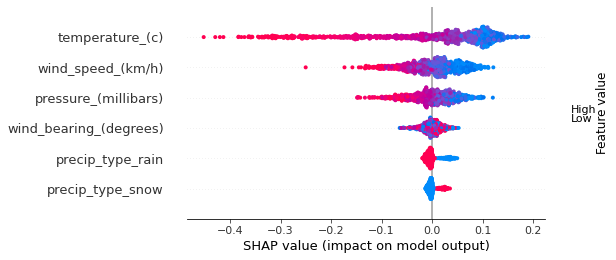

CPU times: user 1min 45s, sys: 9.16 s, total: 1min 54s
Wall time: 1min 6s


In [24]:
pipe_preprocess.fit(x_train)

x = pipe_preprocess.transform(x_train)

explainer = shap.Explainer(final_rfc[-1].predict, x)
shap_values = explainer(pipe_preprocess.transform(x_train.sample(200, random_state=rng)))

# # visualize the first prediction's explanation
shap.plots.beeswarm(shap_values)

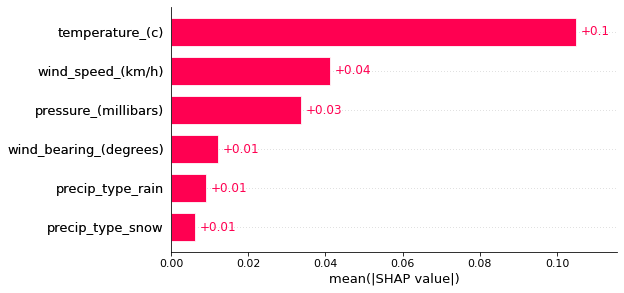

In [25]:
shap.plots.bar(shap_values)

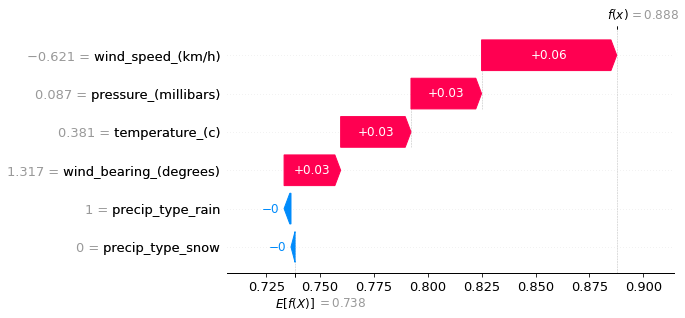

In [26]:
shap.plots.waterfall(shap_values[2])